In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

print('complete')

complete


# Set project and model variables

In [3]:
# Enter your project and region. Then run the  cell to make sure the
# Cloud SDK uses the right project for all the commands in this notebook.

PROJECT = 'mg-ce-demos' # REPLACE WITH YOUR PROJECT NAME 
REGION = 'us-central1' # REPLACE WITH YOUR REGION e.g. us-central1
BUCKET = 'mg-ce-demos-bucket' # REPLACE WITH A UNIQUE BUCKET NAME e.g. your PROJECT NAME
BUCKET_URI = 'gs://' + BUCKET

#Don't change the following command - this is to check if you have changed the project name above.
assert PROJECT != 'your-project-name', 'Don''t forget to change the project variables!'

In [4]:
target = 'total_rides' # The variable you are predicting
target_description = 'Total Rides' # A description of the target variable
features = {'day_type': 'Day Type'} # Weekday = W, Saturday = A, Sunday/Holiday = U
ts_col = 'service_date' # The name of the column with the date field

raw_data_file = 'https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD'
processed_file = 'cta_ridership.csv' # Which file to save the results to

# Import and clean data

In [5]:
# Import CSV file

df = pd.read_csv(raw_data_file, index_col=[ts_col], parse_dates=[ts_col])

In [6]:
# Model data prior to 2020 

df = df[df.index < '2020-01-01']

In [7]:
# Drop duplicates

df = df.drop_duplicates()

In [8]:
# Sort by date

df = df.sort_index()

In [9]:
# Print the top 5 rows

df.head()

,day_type,bus,rail_boardings,total_rides
service_date,,,,
2001-01-01,U,297192,126455,423647
2001-01-02,W,780827,501952,1282779
2001-01-03,W,824923,536432,1361355
2001-01-04,W,870021,550011,1420032
2001-01-05,W,890426,557917,1448343


# Data Exploration

In [10]:
# Initialize plotting

register_matplotlib_converters() # Addresses a warning
sns.set(rc={'figure.figsize':(16,4)})

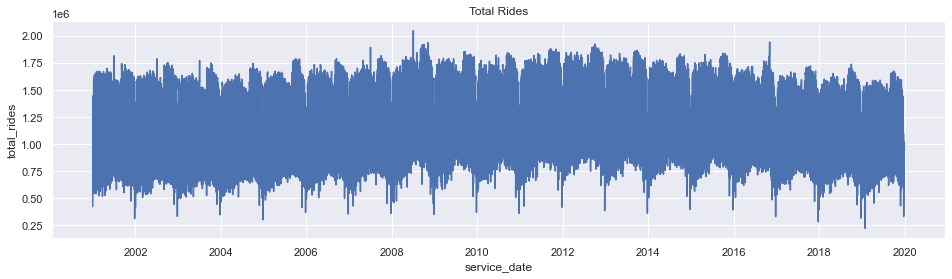

In [11]:
# Explore total rides over time

sns.lineplot(data=df, x=df.index, y=df[target]).set_title('Total Rides')
fig = plt.show()

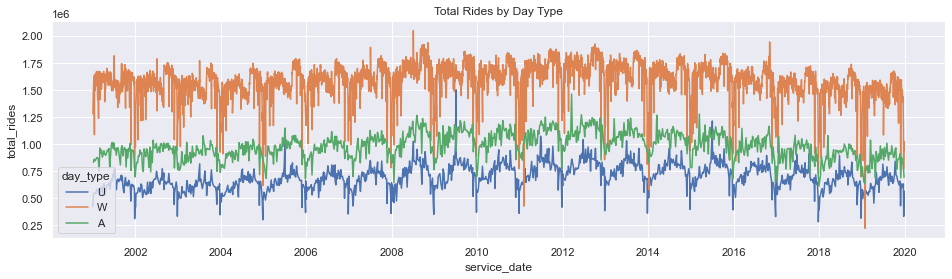

In [12]:
# Explore rides by day type: Weekday (W), Saturday (A), Sunday/Holiday (U)

sns.lineplot(data=df, x=df.index, y=df[target], hue=df['day_type']).set_title('Total Rides by Day Type')
fig = plt.show()

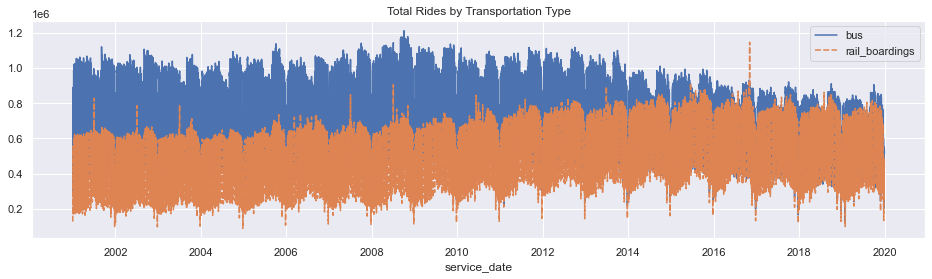

In [13]:
# Explore rides by transportation type

sns.lineplot(data=df[['bus','rail_boardings']]).set_title('Total Rides by Transportation Type')
fig = plt.show()

In [14]:
# Summary stats

df[target].describe().apply(lambda x: round(x))

count       6939
mean     1368761
std       391443
min       222071
25%      1005394
50%      1548343
75%      1660947
max      2049519
Name: total_rides, dtype: int64

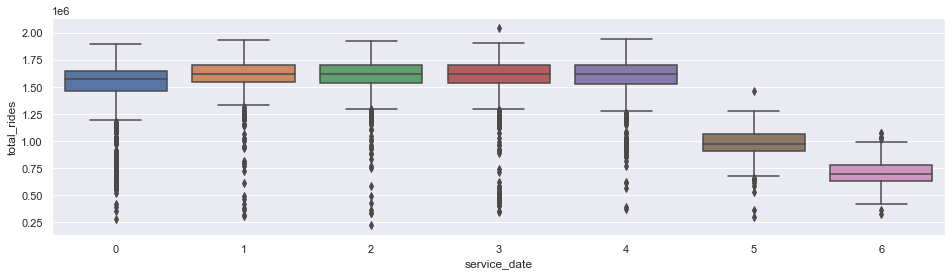

In [15]:
# Show the distribution of values for each day of the week in a boxplot:
# Min, 25th percentile, median, 75th percentile, max 

daysofweek = df.index.to_series().dt.dayofweek

fig = sns.boxplot(x=daysofweek, y=df[target])

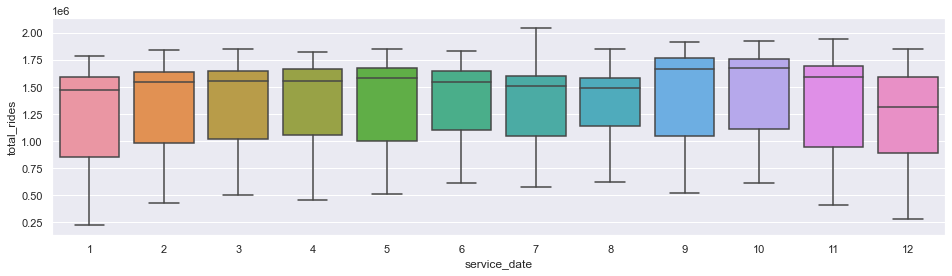

In [16]:
# Show the distribution of values for each month in a boxplot:

months = df.index.to_series().dt.month

fig = sns.boxplot(x=months, y=df[target])

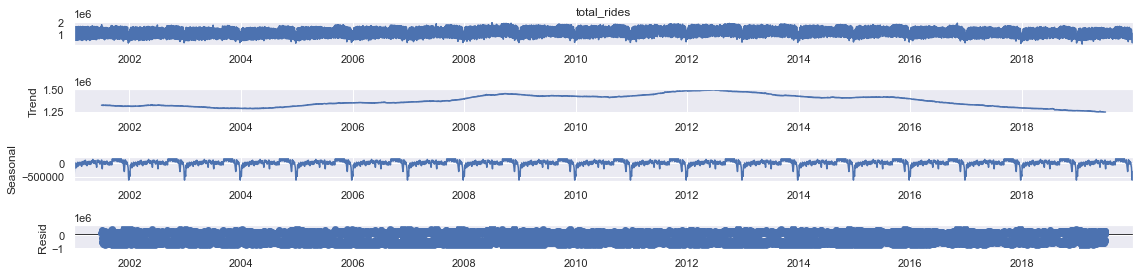

In [17]:
# Decompose the data into trend and seasonal components

result = seasonal_decompose(df[target], period=365)
fig = result.plot()

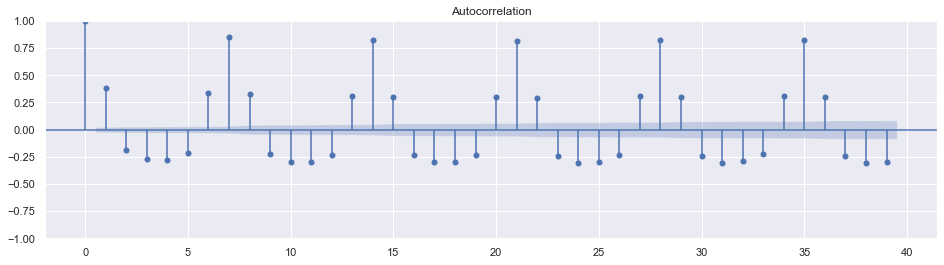

In [18]:
# Auto-correlation

plot_acf(df[target])

fig = plt.show()

In [19]:
#df[[target]].to_csv(processed_file, index=True, index_label=ts_col)  # creates CSV if needed
df = df[[target]]
df.head()

,total_rides
service_date,
2001-01-01,423647
2001-01-02,1282779
2001-01-03,1361355
2001-01-04,1420032
2001-01-05,1448343


# Custom Forecasting ML Model

In [20]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from google.cloud import storage
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, LSTM, MaxPooling1D

register_matplotlib_converters() # Address warning

print('complete')

complete


In [21]:
# Dataset parameters
target_col = 'total_rides' # The variable you are predicting
ts_col = 'service_date' # The name of the column with the date field

# Model parameters
freq = 'D' # Daily frequency
n_input_steps = 30 # Lookback window
n_output_steps = 7 # How many steps to predict forward
n_seasons = 7 # Monthly periodicity

train_split = 0.8 # % Split between train/test data
epochs = 1000 # How many passes through the data (early-stopping will cause training to stop before this)
patience = 5 # Terminate training after the validation loss does not decrease after this many epochs

In [22]:
storage_client = storage.Client()
try:
    bucket = storage_client.get_bucket(BUCKET)
    print('Bucket exists, let''s not recreate it.')
except:
    bucket = storage_client.create_bucket(BUCKET)
    print('Created bucket: ' + BUCKET)

Bucket exists, lets not recreate it.


In [23]:
df.index.freq = freq
df.head()

,total_rides
service_date,
2001-01-01,423647
2001-01-02,1282779
2001-01-03,1361355
2001-01-04,1420032
2001-01-05,1448343


In [24]:
# Define some characteristics of the data that will be used later
n_features = len(df.columns)

# Index of target column. Used later when creating dataframes.
target_col_num = df.columns.get_loc(target_col)

# Split data
size = int(len(df) * train_split)
df_train, df_test = df[0:size].copy(deep=True), df[size:len(df)].copy(deep=True)

df_train.head()

,total_rides
service_date,
2001-01-01,423647
2001-01-02,1282779
2001-01-03,1361355
2001-01-04,1420032
2001-01-05,1448343


In [25]:
df_test.head()

,total_rides
service_date,
2016-03-14,1637335
2016-03-15,1657033
2016-03-16,1656078
2016-03-17,1685170
2016-03-18,1641626


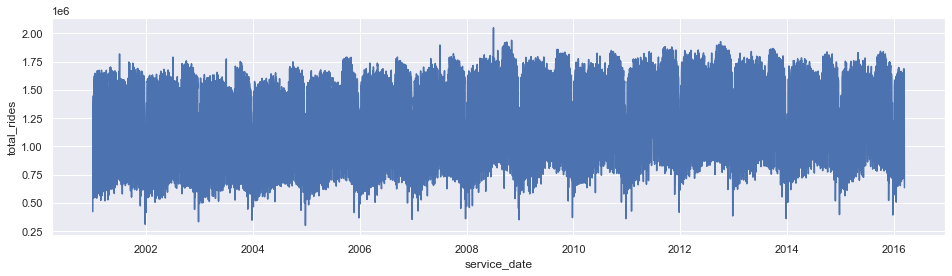

In [26]:
# Removing outliers
_=sns.lineplot(data=df_train[target_col]) 

In [27]:
# top 10 values
df[target_col].sort_values(ascending=False).head(10)

service_date
2008-07-03    2049519
2016-11-04    1945417
2008-11-04    1938738
2012-10-03    1926454
2008-10-01    1922280
2008-10-03    1918959
2008-09-19    1918527
2012-10-02    1914976
2008-09-17    1913446
2008-10-02    1911656
Name: total_rides, dtype: int64

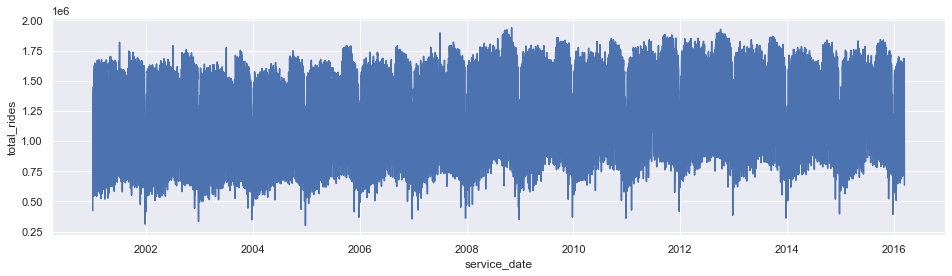

In [28]:
# Update the threshold below to remove the outliers

threshold = 2000000 # Set this just below the level you are seeing peaks. It will flag any values above it.
assert threshold != -1, 'Set the threshold to the minimum that will eliminate outlier(s)'

# Set any values above the threshold to NaN (not a number)
df_train.loc[df_train[target_col] > threshold, target_col] = np.nan

# Interpolate the missing values (e.g. [3, NaN, 5] becomes [3, 4, 5])
df_train = df_train.interpolate()

# Review the updated chart to see if outliers still exist
_=sns.lineplot(data=df_train[target_col])

In [29]:
# For neural networks to converge quicker, it is helpful to scale the values.
# For example, each feature might be transformed to have a mean of 0 and std. dev. of 1.
#
# You are working with a mix of features, input timesteps, output horizon, etc.
# which don't work out-of-the-box with common scaling utilities.
# So, here are a couple wrappers to handle scaling and inverting the scaling.

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

def scale(df, 
          fit=True, 
          target_col=target_col,
          feature_scaler=feature_scaler,
          target_scaler=target_scaler):
    """
    Scale the input features, using a separate scaler for the target.
    
    Parameters: 
    df (pd.DataFrame): Input dataframe
    fit (bool): Whether to fit the scaler to the data (only apply to training data)
    target_col (pd.Series): The column that is being predicted
    feature_scaler (StandardScaler): Scaler used for features
    target_scaler (StandardScaler): Scaler used for target
      
    Returns: 
    df_scaled (pd.DataFrame): Scaled dataframe   
    """    
    
    target = df[target_col].values.reshape(-1, 1)
    if fit:
        target_scaler.fit(target)
    target_scaled = target_scaler.transform(target)
    
    # Select all columns other than target to be features
    features = df.loc[:, df.columns != target_col].values
    
    if features.shape[1]:  # If there are any features
        if fit:
            feature_scaler.fit(features)
        features_scaled = feature_scaler.transform(features)
        
        # Combine target and features into one data frame
        df_scaled = pd.DataFrame(features_scaled)
        target_col_num = df.columns.get_loc(target_col)
        df_scaled.insert(target_col_num, target_col, target_scaled)
        df_scaled.columns = df.columns        
    
    else:  # If only target column (no additional features)
        df_scaled = pd.DataFrame(target_scaled, columns=df.columns)
      
    return df_scaled

def inverse_scale(data, target_scaler=target_scaler):
    """
    Transform the scaled values of the target back into their original form.
    The features are left alone, as we're assuming that the output of the model only includes the target.
    
    Parameters: 
    data (np.array): Input array
    target_scaler (StandardScaler): Scaler used for target
      
    Returns: 
    data_scaled (np.array): Scaled array   
    """    
    
    df = pd.DataFrame()
    data_scaled = np.empty([data.shape[1], data.shape[0]])
    for i in range(data.shape[1]):
        data_scaled[i] = target_scaler.inverse_transform([data[:,i]])
    return data_scaled.transpose()

df_train_scaled=scale(df_train)
df_test_scaled=scale(df_test, False)

In [30]:
# create sequences of time series data
def reframe(data, n_input_steps = n_input_steps, n_output_steps = n_output_steps, target_col = target_col):

    target_col_num = data.columns.get_loc(target_col)    
    
    # Iterate through data and create sequences of features and outputs
    df = pd.DataFrame(data)
    cols=list()
    for i in range(n_input_steps, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_output_steps):
        cols.append(df.shift(-i))
        
    # Concatenate values and remove any missing values
    df = pd.concat(cols, axis=1)
    df.dropna(inplace=True)
    
    # Split the data into feature and target variables
    n_feature_cols = n_input_steps * n_features
    features = df.iloc[:,0:n_feature_cols]
    target_cols = [i for i in range(n_feature_cols + target_col_num, n_feature_cols + n_output_steps * n_features, n_features)]
    targets = df.iloc[:,target_cols]

    return (features, targets)

X_train_reframed, y_train_reframed = reframe(df_train_scaled)
X_test_reframed, y_test_reframed = reframe(df_test_scaled)

In [31]:
# eval results
def print_stats(timestep, y_true, y_pred, target_col, chart=True, table=False, dec=3):
    '''
    Helper function to print overall summary statistics and stats for each time step
    '''
    
    # Print summary statistics
    print('=== t+' + str(timestep) + ' ===')
    print('R^2:  ' + str(np.round(r2_score(y_true, y_pred), dec)))
    print('MAPE: ' + str(np.round(mean_absolute_percentage_error(y_true, y_pred), dec)))
    print('MAE:  ' + str(np.round(mean_absolute_error(y_true, y_pred), dec)))
    print('')

    df_y_true = pd.DataFrame(y_true)
    df_y_true[target_col + '_pred'] = np.round(y_pred, dec)
    
    # Show plot of actuals vs predictions and a sample of values
    if table:
        print(str(df_y_true.head(5)) + '\n')
        print(str(df_y_true.tail(5)) + '\n')
    if chart:
        sns.lineplot(data=df_y_true[[target_col, target_col+'_pred']])
        plt.show()
        
def evaluate(y_pred,
             exclude_timesteps=n_input_steps,
             y_true=df_test,
             target_col=target_col):
    '''
    Helper function to transform predictions to match size and indices of actuals.
    
    For example, n_timesteps from the test data will be required to make a prediction,
    so the number of predictions will be fewer than the number of test samples.
    
    Parameters:
    y_pred (np.array): Predictions
    exclude_timesteps (int): Number of leading timesteps to trim from the dataset
    y_true (pd.DataFrame): Actuals
    '''
        
    # Number of outputs (future timesteps)
    outputs = y_pred.shape[1]
    
    target_col_num = df.columns.get_loc(target_col)
    
    # Lists of actual and predicted values for each time step
    # For example, y_true_eval[2] will contain actual values 3 time steps out
    # These specific lists enable computing the accuracy for specific time steps
    y_true_eval, y_pred_eval = list(), list()

    # Actual and predicted values combined across all time steps (to compute overall accuracy metrics)
    y_true_all, y_pred_all = np.array([]), np.array([])
    
    # Append entries to lists for each output timestep
    for t in range(outputs):
        if exclude_timesteps:
            y_true_eval.append(y_true[exclude_timesteps+t:len(y_true)-outputs+t+1].copy())
            y_pred_eval.append(y_pred[:,t])          
        else:
            y_true_eval.append(y_true[t:].copy())
            y_pred_eval.append(y_pred[:-1*t-1,t])
        # Append the output values to the combined lists
        y_true_all = np.concatenate([y_true_all, y_true_eval[t].values[:,target_col_num]], axis=0)
        y_pred_all = np.concatenate([y_pred_all, y_pred_eval[t]], axis=0)

    # Print aggregate statistics across all time steps (only if predicting multiple time steps)
    if outputs > 1:
        print_stats('(1-' + str(outputs) + ')', y_true_all, y_pred_all, target_col, False)

    # Print stats for each future time step
    for t in range(outputs):    
        print_stats(t+1, y_true_eval[t][target_col], y_pred_eval[t], target_col, True)

In [32]:
# Reshape test data to match model inputs and outputs, necessary for neural networks

X_train = X_train_reframed.values.reshape(-1, n_input_steps, n_features)
X_test = X_test_reframed.values.reshape(-1, n_input_steps, n_features)
y_train = y_train_reframed.values.reshape(-1, n_output_steps, 1)
y_test = y_test_reframed.values.reshape(-1, n_output_steps, 1)

# Train models - in notebook

## LSTM

In [ ]:
%%time
# Try increasing and decreasing the number of LSTM units and see if you notice any accuracy improvements.
# Run the next cell to evaluate the results in more detail.

model = Sequential([
    LSTM(64, input_shape=[n_input_steps, n_features]),
    Dense(n_output_steps)])

model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
_ = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])

In [ ]:
model.save('./lstm_export/')

In [ ]:
%%time
# Predict the results, and then reverse the transformation that scaled all values to a mean of 0 and std. dev. of 1
preds = model.predict(X_test)
y_pred_lstm = inverse_scale(preds)
y_pred_lstm
# Evaluate the overall results and for each time step
#evaluate(y_pred_lstm)

# The plot will show the R^2 value (0 lowest -> 1 highest) and the MAE (mean absolute error) for the entire prediction window.
# It will also show individual plots for 1 day out, 2 days out, etc. comparing the actual vs the predicted value.

## CNN

In [ ]:
%%time
from tensorflow.keras.layers import AveragePooling1D

# Try adjusting the # of filters (pattern types) and kernel size (size of the sliding window)
model = Sequential([
    Conv1D(filters=32, kernel_size=3, input_shape=[n_input_steps, n_features]),
    Flatten(),
    Dense(n_output_steps)])

model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
_ = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])

In [ ]:
model.save('./cnn_export/')

In [ ]:
%%time 

preds = model.predict(X_test)
y_pred_cnn = inverse_scale(preds)

evaluate(y_pred_cnn)

## Naïve Models

### Random Walk

In [ ]:
%%time
from statsmodels.tsa.arima.model import ARIMA

hist = df_train[target_col].copy() # Predict based on historical data. Start with the training data
hist.index.freq = pd.infer_freq(hist.index) # To avoid warnings, explicitly specify the dataframe frequency
n_pred = len(df_test) + 1 # Number of predictions: 1 on the training set; and then 1 for each additional 
y_pred_rw = np.empty([n_pred,n_output_steps]) # Create an array to hold predictions, with a number of predictions equal to the test set size, each containing the # of time steps you are predicting forward.

for t in range(n_pred):
    mod = ARIMA(hist, order=(0, 1, 0))
    res = mod.fit()
    pred = res.forecast(n_output_steps)
    y_pred_rw[t] = pred.values
    if t < n_pred - 1:
        hist.loc[df_test.iloc[t].name] = df_test[target_col][t] # Append the latest test data row to the history, for fitting the next model
        hist.index.freq = pd.infer_freq(hist.index)

In [ ]:
evaluate(y_pred_rw, 0)

### Seasonal Naïve

In [ ]:
%%time
# You will use a walk-forward approach, in which a model is fit on all historical data available.
# As you progress through the test set to evaluate the model, you will be creating new models for each row in the test set.
# Each new model will be fit on not only the training data, but on prior test data.

from statsmodels.tsa.statespace.sarimax import SARIMAX

hist = df_train[target_col].copy() # Predict based on historical data. Start with the training data
hist.index.freq = pd.infer_freq(hist.index) # To avoid warnings, explicitly specify the dataframe frequency
n_pred = len(df_test) + 1 # Number of predictions: 1 on the training set; and then 1 for each additional 
y_pred_sn = np.empty([n_pred,n_output_steps]) # Create an array to hold predictions, with a number of predictions equal to the test set size, each containing the # of time steps you are predicting forward.

for t in range(n_pred):
    mod = SARIMAX(hist, order=(0, 0, 0), seasonal_order=(0, 1, 0, n_seasons))
    res = mod.fit(disp=False)
    pred = res.forecast(n_output_steps)
    y_pred_sn[t] = pred.values
    if t < n_pred - 1:
        hist.loc[df_test.iloc[t].name] = df_test[target_col][t] # Append the latest test data row to the history, for fitting the next model
        hist.index.freq = pd.infer_freq(hist.index)

In [ ]:
evaluate(y_pred_sn, 0)

## Statistical Models

### Exponential Smoothing

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
%%time
# You will use a walk-forward approach, in which a model is fit on all historical data available.
# As you progress through the test set to evaluate the model, you will be creating new models for each row in the test set.
# Each new model will be fit on not only the training data, but on prior test data.

hist = df_train[target_col].copy() # Predict based on historical data. Start with the training data
hist.index.freq = pd.infer_freq(hist.index) # To avoid warnings, explicitly specify the dataframe frequency
n_pred = len(df_test) + 1 # Number of predictions: 1 on the training set; and then 1 for each additional 
y_pred_es = np.empty([n_pred,n_output_steps]) # Create an array to hold predictions, with a number of predictions equal to the test set size, each containing the # of time steps you are predicting forward.

for t in range(n_pred):
    mod = ExponentialSmoothing(hist, seasonal_periods=n_seasons, trend='add', seasonal='add', damped_trend=True, use_boxcox=False, initialization_method='heuristic')
    res = mod.fit(method='L-BFGS-B')  # Use a different minimizer to avoid convergence warnings
    pred = res.forecast(n_output_steps)
    y_pred_es[t] = pred.values
    if t < n_pred - 1:
        hist.loc[df_test.iloc[t].name] = df_test[target_col][t] # Append the latest test data row to the history, for fitting the next model
        hist.index.freq = pd.infer_freq(hist.index)

In [ ]:
evaluate(y_pred_es, 0)

###  Ensemble ML and Statistical Models

In [ ]:
%%time
# Start by adjusting the sizes of the prediction arrays to match.
# Some methods predict the initial timesteps of the test set.
# Others start after the first sequence length.
# So, you will remove the test data that doesn't exist in both sets.

def trunc(df, test_set=df_test, n_input_steps = n_input_steps, n_output_steps = n_output_steps):
    return df[n_input_steps: -n_output_steps]

y_pred_es_trunc = trunc(y_pred_es)
y_true_trunc = trunc(df_test)

In [ ]:
%%time

models = [y_pred_lstm, y_pred_cnn, y_pred_es_trunc]
weights = [2, 1, 1]

y_pred_ensemble = np.average( np.array(models), axis=0, weights=weights)

evaluate(y_pred_ensemble, 0, y_true_trunc)

# Train models - in Vertex

In [33]:
import datetime
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf

from google.cloud import aiplatform, storage
from google.cloud.aiplatform import gapic as aip
from sklearn.preprocessing import StandardScaler

print('complete')

complete


In [34]:
# Check the TensorFlow version installed

tf.__version__

'2.7.0'

In [35]:
# Initialize the Vertex SDK for Python

aiplatform.init(project=PROJECT, location=REGION, staging_bucket=BUCKET)

In [36]:
# Dataset parameters

target_col = 'total_rides' # The variable you are predicting
ts_col = 'service_date' # The name of the column with the date field

# Model parameters

freq = 'D' # Daily frequency
n_input_steps = 30 # Lookback window
n_output_steps = 7 # How many steps to predict forward
n_seasons = 7 # Monthly periodicity

train_split = 0.8 # % Split between train/test data
epochs = 1000 # How many passes through the data (early-stopping will cause training to stop before this)
patience = 5 # Terminate training after the validation loss does not decrease after this many epochs

lstm_units = 64
input_layer_name = 'lstm_input'

# Training parameters

MODEL_NAME = 'cta_ridership'

In [37]:
# Specify directories to be used later

TRAINER_DIR = 'trainer'
EXPORT_DIR = 'tf_export'

In [38]:
# Create trainer directory if it doesn't already exist

!mkdir $TRAINER_DIR

mkdir: trainer: File exists


In [39]:
# Copy numpy arrays to npy files

np.save(TRAINER_DIR + '/x_train.npy', X_train)
np.save(TRAINER_DIR + '/x_test.npy', X_test)
np.save(TRAINER_DIR + '/y_train.npy', y_train)
np.save(TRAINER_DIR + '/y_test.npy', y_test)

## Prepare model code

In [40]:
# Write training code out to a file that will be submitted to the training job
# Note: f-strings are supported in Python 3.6 and above

model_template = f"""import argparse
import numpy as np
import os
import tempfile

from google.cloud import storage
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

n_features = {n_features} # Two features: y (previous values) and whether the date is a holiday
n_input_steps = {n_input_steps} # Lookback window
n_output_steps = {n_output_steps} # How many steps to predict forward

epochs = {epochs} # How many passes through the data (early-stopping will cause training to stop before this)
patience = {patience} # Terminate training after the validation loss does not decrease after this many epochs

def download_blob(bucket_name, source_blob_name, destination_file_name):
    '''Downloads a blob from the bucket.'''
    # bucket_name = "your-bucket-name"
    # source_blob_name = "storage-object-name"
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)

    # Construct a client side representation of a blob.
    # Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
    # any content from Google Cloud Storage. As we don't need additional data,
    # using `Bucket.blob` is preferred here.
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print("Blob " + source_blob_name + " downloaded to " + destination_file_name + ".")

def extract_bucket_and_prefix_from_gcs_path(gcs_path: str):
    '''Given a complete GCS path, return the bucket name and prefix as a tuple.

    Example Usage:

        bucket, prefix = extract_bucket_and_prefix_from_gcs_path(
            "gs://example-bucket/path/to/folder"
        )

        # bucket = "example-bucket"
        # prefix = "path/to/folder"

    Args:
        gcs_path (str):
            Required. A full path to a Google Cloud Storage folder or resource.
            Can optionally include "gs://" prefix or end in a trailing slash "/".

    Returns:
        Tuple[str, Optional[str]]
            A (bucket, prefix) pair from provided GCS path. If a prefix is not
            present, a None will be returned in its place.
    '''
    if gcs_path.startswith("gs://"):
        gcs_path = gcs_path[5:]
    if gcs_path.endswith("/"):
        gcs_path = gcs_path[:-1]

    gcs_parts = gcs_path.split("/", 1)
    gcs_bucket = gcs_parts[0]
    gcs_blob_prefix = None if len(gcs_parts) == 1 else gcs_parts[1]

    return (gcs_bucket, gcs_blob_prefix)

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--data-uri',
        default=None,
        help='URL where the training files are located')
    args = parser.parse_args()
    print(args)
    return args

def main():
    args = get_args()
    bucket_name, blob_prefix = extract_bucket_and_prefix_from_gcs_path(args.data_uri)
    
    # Get the training data and convert back to np arrays
    local_data_dir = os.path.join(os.getcwd(), tempfile.gettempdir())
    files = ['x_train.npy', 'y_train.npy', 'x_test.npy', 'y_test.npy']
 
    for file in files:
        download_blob(bucket_name, os.path.join(blob_prefix,file), os.path.join(local_data_dir,file))

    X_train = np.load(local_data_dir + '/x_train.npy')
    y_train = np.load(local_data_dir + '/y_train.npy')
    X_test = np.load(local_data_dir + '/x_test.npy')
    y_test = np.load(local_data_dir + '/y_test.npy')
        
    # Build and train the model
    model = Sequential([
        LSTM({lstm_units}, input_shape=[n_input_steps, n_features], recurrent_activation=None),
        Dense(n_output_steps)])

    model.compile(optimizer='adam', loss='mae')

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
    _ = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])
    
    # Export the model
    model.save(os.environ["AIP_MODEL_DIR"])
    
if __name__ == '__main__':
    main()
"""

with open(os.path.join(TRAINER_DIR, 'task.py'), 'w') as f:
    f.write(model_template.format(**globals()))

In [41]:
# Copy the data files to a GCS bucket
# if running locally, may need to activate your SA: gcloud auth activate-service-account --key-file KEY_FILE

!gsutil -m cp -r trainer/*.npy $BUCKET_URI/$TRAINER_DIR

If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Copying file://trainer/x_test.npy [Content-Type=application/octet-stream]...
Copying file://trainer/x_train.npy [Content-Type=application/octet-stream]...   
Copying file://trainer/y_test.npy [Content-Type=application/octet-stream]...    
Copying file://trainer/y_train.npy [Content-Type=application/octet-stream]...   
/ [4/4 files][  1.9 MiB/  1.9 MiB] 100% Done                                    
Operation completed over 4 objects/1.9 MiB.                                      


In [42]:
# List the contents of the bucket to ensure they were copied properly

!gsutil ls $BUCKET_URI/$TRAINER_DIR

gs://mg-ce-demos-bucket/trainer/x_test.npy
gs://mg-ce-demos-bucket/trainer/x_train.npy
gs://mg-ce-demos-bucket/trainer/y_test.npy
gs://mg-ce-demos-bucket/trainer/y_train.npy


## Submit training job

In [43]:
# Set training job parameters

CMDARGS = [
    f"--data-uri={BUCKET_URI}/{TRAINER_DIR}"
]
TRAIN_VERSION = "tf-cpu.2-6"
DEPLOY_VERSION = "tf2-cpu.2-6"

TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(DEPLOY_VERSION)

# Re-run these additional parameters if you need to create a new training job

TIMESTAMP = str(datetime.datetime.now().time())
JOB_NAME = 'vertex_ai_training_' + TIMESTAMP
MODEL_DISPLAY_NAME = MODEL_NAME + TIMESTAMP

In [44]:
%%time
# Create and run the training job

job = aiplatform.CustomTrainingJob(
    display_name=JOB_NAME,
    script_path=f"{TRAINER_DIR}/task.py",
    container_uri=TRAIN_IMAGE,
    model_serving_container_image_uri=DEPLOY_IMAGE,
)

model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
)

INFO:google.cloud.aiplatform.utils.source_utils:Training script copied to:
gs://mg-ce-demos-bucket/aiplatform-2022-03-29-13:11:04.378-aiplatform_custom_trainer_script-0.1.tar.gz.
INFO:google.cloud.aiplatform.training_jobs:Training Output directory:
gs://mg-ce-demos-bucket/aiplatform-custom-training-2022-03-29-13:11:05.204 
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8363787590154846208?project=633472233130
INFO:google.cloud.aiplatform.training_jobs:View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/3585222094910128128?project=633472233130
INFO:google.cloud.aiplatform.training_jobs:CustomTrainingJob projects/633472233130/locations/us-central1/trainingPipelines/8363787590154846208 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:CustomTrainingJob projects/633472233130/locations/us-central1/trainingPipelin

# Deploy the model - in Vertex

In [52]:
DEPLOYED_NAME = f"{MODEL_NAME}_deployed-" + TIMESTAMP

endpoint = model.deploy(
    deployed_model_display_name=DEPLOYED_NAME,
    machine_type="n1-standard-4",
    min_replica_count=1,
    max_replica_count=1,
    traffic_split={"0": 100},
)

# may need to manually stop the cell, sometimes doesn't complete even after model is deployed successfully

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/633472233130/locations/us-central1/endpoints/6172086532288020480/operations/6740360939486314496
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/633472233130/locations/us-central1/endpoints/6172086532288020480
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/633472233130/locations/us-central1/endpoints/6172086532288020480')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/633472233130/locations/us-central1/endpoints/6172086532288020480
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/633472233130/locations/us-central1/endpoints/6172086532288020480/operations/5992763401342812160


KeyboardInterrupt: 

# Get predictions on deployed model - in Vertex

In [57]:
# Set endpoint ID if needing to manually exit previous cell
endpoint_id = "4061587156911521792" # Find in console, Vertex AI -> Endpoints -> ID (for relevant model)
endpoint = aiplatform.Endpoint(endpoint_id)

In [98]:
# Get predictions for the first test instance

raw_predictions = endpoint.predict(instances=X_test.tolist()).predictions[0]
predicted_values = inverse_scale(np.array([raw_predictions])).round()

actual_values = inverse_scale(np.array([[i[0] for i in y_test[0]]]))

# Print prediction and compare to actual value

print('Predicted riders:', predicted_values)
print('Actual riders:   ', actual_values)
print('Difference:      ', np.array(predicted_values - actual_values))

Predicted riders: [[1662913. 1654025. 1644617. 1005859.  685891. 1639491. 1641208.]]
Actual riders:    [[1647321. 1668584. 1687618. 1060043.  786217. 1517370. 1506995.]]
Difference:       [[  15592.  -14559.  -43001.  -54184. -100326.  122121.  134213.]]


# Cleanup - if needed

In [ ]:
delete_training_job = True
delete_model = True
delete_endpoint = True

# Warning: Setting this to true will delete everything in your bucket
delete_bucket = False

# Delete the training job
job.delete()

# Delete the endpoint
endpoint.delete(force=True)

# Delete the model
model.delete()

# Warning: uncomment this section only if you want to delete the entire bucket
# if delete_bucket and "BUCKET" in globals():
#     ! gsutil -m rm -r $BUCKET